# Problem 3: Google Playstore Apps Dataset

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
df = pd.read_excel('GooglePlaystore.xlsx')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,2018-01-07 00:00:00,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2018-01-15 00:00:00,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,2018-08-01 00:00:00,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,2018-06-08 00:00:00,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,2018-06-20 00:00:00,1.1,4.4 and up


## PART 1: PREPROCESSING

1.1 Often there are outliers which do not match the overall data type. There is one record in this data where the "Reviews" has value "3.0M" which does not match the rest of the data. Remove that record.

In [3]:
# Delete row where 'Reviews' == 3.0M
df = df[df['Reviews'] != '3.0M']

1.2 Remove rows where any of the columns has the value "Varies with device".

In [4]:
# Delete rows where any column == 'Varies with device'
df = df[~df.isin(['Varies with device']).any(axis=1)]

1.3 The values in the Android version column should be floats. Strip the trailing non-numeric characters from all values (ie. the words " and up"), so the result is a number. If there are multiple decimal places (eg. "x.y.z"), keep only the first two parts (eg "x.y"). For example, the value "4.1 and up" should be changed to "4.1". The value "4.5.6 and up" should be changed to "4.5". The value "5.6.7" should be changed to "5.6".

In [5]:
# Strip trailing non-numeric characters from Android version
def clean_ver(ver):
    match = re.search('\d+\.\d+', str(ver))
    if match:
        return float(match.group())
    return np.nan

df['Android Ver'] = df['Android Ver'].apply(clean_ver)

1.4 The "Installs" column must have integer values. For values that have commas, remove the commas. For values that have a '+' at the end, remove the '+'. Keep only those rows that have an integer value after these edits.

In [6]:
# Convert installs to int and drop other rows
def clean_installs(installs):
    ret = re.sub('[,\+]', '', installs)
    try:
        ret = int(ret)
    except ValueError as ex:
        ret = np.nan
    return ret

df['Installs'] = df['Installs'].apply(clean_installs)
df = df[df['Installs'] != np.nan]

1.5 For missing rating values, if the number of reviews is less than 100 and installations is less than 50000, remove the row. Else, fill the missing value with the average value (rounded to 2 decimal places) for the Category of that row.

In [7]:
# Fill missing ratings and drop unrated unpopular apps
df = df[((df['Installs'] >= 50000) | (df['Reviews'] >= 100)) | ~df['Rating'].isna()]
df['Rating'] = df.groupby('Category')['Rating'].apply(lambda x: x.fillna(round(x.mean(), 2)))

1.6 Preprocess the Size column to convert the "M" (millions) and "K" (thousands) values into integers. For instance, 8.7M should be converted to 8700000 and 2.4K should be converted to 2400.

In [8]:
# Turn size into int
def clean_size(size):
    match = re.search("(?P<num>\d*\.?\d+)(?P<exp>\w)", size)
    if (match):
        mdict = match.groupdict()
        xdict = {'M' : 6, 'K' : 3}
        num = float(mdict['num'])
        exp = xdict[mdict['exp'].upper()]
        return num * (10 ** exp)
    return size

df['Size'] = df['Size'].apply(clean_size)

In [9]:
# Other dtype conversion and final results
df[['Reviews', 'Price']] = df[['Reviews', 'Price']].apply(pd.to_numeric)

df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07 00:00:00,1.0.0,4.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15 00:00:00,2.0.0,4.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,Art & Design,2018-08-01 00:00:00,1.2.4,4.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20 00:00:00,1.1,4.4
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5600000.0,50000,Free,0.0,Everyone,Art & Design,2017-03-26 00:00:00,1,2.3


## PART 2: ANALYSIS

2.1  Describe (use DataFrame describe method) the category wise rating statistics. In other words, for each category, describe the statistics (count, mean, etc.) for ratings in that category.

In [10]:
# Ratings data by category
stats = pd.DataFrame()
for category in df['Category'].unique():
    row = dict({'category': category}, **df[df['Category'] == category]['Rating'].describe().to_dict())
    if (stats.empty):
        stats = pd.DataFrame(row, index=[0])
    else:
        stats = stats.append(row, ignore_index=True)
stats

,category,count,mean,std,min,25%,50%,75%,max
0,ART_AND_DESIGN,59.0,4.358644,0.365322,3.2,4.100,4.40,4.700,5.0
1,AUTO_AND_VEHICLES,62.0,4.146774,0.569935,2.1,3.900,4.25,4.500,4.9
2,BEAUTY,40.0,4.291750,0.356175,3.1,4.075,4.30,4.525,4.9
3,BOOKS_AND_REFERENCE,147.0,4.320136,0.453084,2.7,4.100,4.40,4.600,5.0
4,BUSINESS,246.0,4.119187,0.662586,1.0,3.825,4.30,4.500,5.0
5,COMICS,49.0,4.154082,0.550363,2.8,3.800,4.40,4.600,5.0
6,COMMUNICATION,210.0,4.100952,0.502624,1.0,3.900,4.20,4.400,5.0
7,DATING,174.0,3.957816,0.664204,1.0,3.600,4.10,4.400,5.0
8,EDUCATION,110.0,4.392636,0.254395,3.5,4.300,4.40,4.600,4.9
9,ENTERTAINMENT,86.0,4.145349,0.291308,3.0,4.000,4.20,4.300,4.7


2.2 Extract all "Free" apps from the master data frame. Then write a function that, given a numeric column e.g 'Rating'), will create and return a dataframe for the top 3 free applications in each category based on that column. Call the function on each of these columns:

In [11]:
# Statistics on free apps
free_df = df[df['Type'] == 'Free']

def top3(df, column):
    return df.nlargest(3, column)

2.2.a Rating (gives top 3 most highly rated applications in each category)

In [12]:
# Top 3 free apps by rating
top3(free_df, 'Rating')[['App', 'Category', 'Rating']]

,App,Category,Rating
329,Hojiboy Tojiboyev Life Hacks,COMICS,5.0
612,American Girls Mobile Numbers,DATING,5.0
615,Awake Dating,DATING,5.0


2.2.b Installs (gives top 3 most installed applications in each category)

In [13]:
# Top 3 free apps by installs
top3(free_df, 'Installs')[['App', 'Category', 'Installs']]

,App,Category,Installs
1654,Subway Surfers,GAME,1000000000
1700,Subway Surfers,GAME,1000000000
1750,Subway Surfers,GAME,1000000000


2.2.c Reviews (gives top 3 most reviewed applications in each category) 

In [14]:
# Top 3 free apps by most reviews
top3(free_df, 'Reviews')[['App', 'Category', 'Reviews']]

,App,Category,Reviews
1879,Clash of Clans,GAME,44893888
1670,Clash of Clans,GAME,44891723
1704,Clash of Clans,GAME,44891723


2.3 Find the average, maximum and minimum price of the paid applications.

In [15]:
# Statistics on paid apps
paid_df = df[df['Type'] == 'Paid']
paid_df['Price'].describe()[['mean', 'min', 'max']]

mean     15.139164
min       0.990000
max     400.000000
Name: Price, dtype: float64

## PART 3: VISUALIZATION

3.1 In the genre column, break the string of genres into a list. For example, ‘Art & Design; Creativity’ should be [‘Art & Design’, Creativity’]. Count the number of applications per genre and display it using a pie chart.

In [16]:
# Break string of genres into list
def clean_genres(genres):
    genrelist = genres.split(';')
    return genrelist

df['Genres'] = df['Genres'].apply(clean_genres)

Text(0.5, 1.0, 'Applications per Genre')

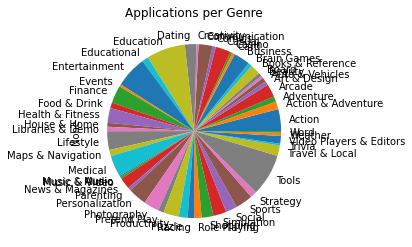

In [31]:
# Ugly piechart
pie = df.explode('Genres').groupby('Genres').size().plot.pie()
pie.set_title('Applications per Genre')

3.2 Display a box plot of ratings for "Business" and "Education" categories. The boxplots should be in the same plot.

Text(0.5, 0, 'Category')

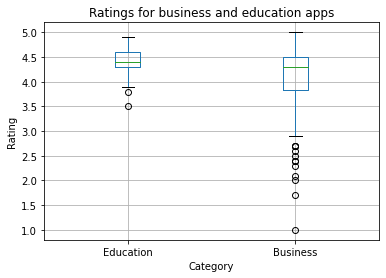

In [27]:
# Ugly boxplots
edu = df[df['Category'] == 'EDUCATION']['Rating']
bn = df[df['Category'] == 'BUSINESS']['Rating']
bplotdf = pd.concat([edu, bn], axis=1)
bplotdf.columns = ['Education', 'Business']
bplot = bplotdf.boxplot()
bplot.set_title('Ratings for Business and Education apps')
bplot.set_ylabel('Rating')
bplot.set_xlabel('Category')